# 🤖 03 — Model Baseline (Logistic Regression)

Objetivo:
- Carregar o Gold Dataset (`gold_2012_2023.parquet`)
- Gerar features temporais (rolling / strength / home advantage)
- Treinar Logistic Regression multinomial (pipeline com scaler)
- Avaliar com Log Loss e Brier Score
- Salvar modelo e métricas

Saídas:
- `models/logreg_baseline.pkl`
- `reports/baseline_metrics.json`


In [1]:
from google.colab import drive
drive.mount("/content/drive")

import sys
from pathlib import Path
import json
import joblib

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

PROJECT = Path("/content/drive/MyDrive/DataProjects/BRMP-Brazilian-Match-Prediction")
PROCESSED = PROJECT / "data" / "processed"
MODELS_DIR = PROJECT / "models"
REPORTS = PROJECT / "reports"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS.mkdir(parents=True, exist_ok=True)

# permitir imports do src/
sys.path.insert(0, str(PROJECT))

PROCESSED, MODELS_DIR


Mounted at /content/drive


(PosixPath('/content/drive/MyDrive/DataProjects/BRMP-Brazilian-Match-Prediction/data/processed'),
 PosixPath('/content/drive/MyDrive/DataProjects/BRMP-Brazilian-Match-Prediction/models'))

In [2]:
gold_path = PROCESSED / "gold_2012_2023.parquet"
assert gold_path.exists(), f"Gold não encontrado: {gold_path}"

df_base = pd.read_parquet(gold_path).copy()
df_base["data"] = pd.to_datetime(df_base["data"], errors="coerce")
df_base = df_base.dropna(subset=["data"]).sort_values("data").reset_index(drop=True)

df_base.shape, df_base.head(3)


((4559, 9),
         data  ano_campeonato time_mandante time_visitante  gols_mandante  \
 0 2012-05-19            2012     Palmeiras     Portuguesa            1.0   
 1 2012-05-19            2012  Sport Recife    Flamengo RJ            1.0   
 2 2012-05-20            2012   Figueirense        Nautico            2.0   
 
    gols_visitante resultado    home_norm   away_norm  
 0             1.0         D    palmeiras  portuguesa  
 1             1.0         D        sport    flamengo  
 2             1.0         H  figueirense     nautico  )

In [3]:
from src.data.features import build_features, FeatureConfig, split_by_year, make_model_matrix

cfg = FeatureConfig(rolling_n=5)

df_feat = build_features(df_base, cfg)
df_feat.shape


(4559, 55)

In [10]:
splits = split_by_year(df_feat, train_end=2022, test_year=2023, context_year=None)



In [11]:
# 🔒 BASELINE — FEATURES PERMITIDAS (SEM VAZAMENTO)
BASELINE_FEATURES = [
    "ano_campeonato",

    # médias da liga
    "league_gf_home_mean",
    "league_gf_away_mean",
    "league_total_goals_mean",

    # home rolling
    "home_gf_roll",
    "home_ga_roll",
    "home_gf_roll_home",
    "home_ga_roll_home",
    "home_gf_roll_away",
    "home_ga_roll_away",
    "home_games_played_lag1",

    # away rolling
    "away_gf_roll",
    "away_ga_roll",
    "away_gf_roll_home",
    "away_ga_roll_home",
    "away_gf_roll_away",
    "away_ga_roll_away",
    "away_games_played_lag1",

    # força relativa
    "home_attack_roll",
    "home_defense_roll",
    "away_attack_roll",
    "away_defense_roll",
    "attack_gap",
    "defense_gap",
]


In [12]:
X_train = splits["train"][BASELINE_FEATURES].copy()
y_train = splits["train"]["resultado"].copy()

X_test = splits["test"][BASELINE_FEATURES].copy()
y_test = splits["test"]["resultado"].copy()

In [13]:
print("NAs no treino:")
display(X_train.isna().mean().sort_values(ascending=False).head())

print("Shape:", X_train.shape, X_test.shape)


NAs no treino:


,0
home_ga_roll_away,0.010768
home_gf_roll_away,0.010768
away_gf_roll_home,0.010529
away_ga_roll_home,0.010529
attack_gap,0.005982


Shape: (4179, 24) (380, 24)


In [16]:
means = X_train.mean()

X_train = X_train.fillna(means)
X_test  = X_test.fillna(means)


In [17]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()


(np.int64(0), np.int64(0))

In [18]:
logreg = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=2000,
            n_jobs=-1,
            random_state=42
        ))
    ]
)

logreg.fit(X_train, y_train)
print("✅ Baseline treinado")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Baseline treinado


In [19]:
proba = logreg.predict_proba(X_test)
classes = logreg.named_steps["model"].classes_
pred = logreg.predict(X_test)

ll = log_loss(y_test, proba, labels=classes)
acc = accuracy_score(y_test, pred)

y_bin = label_binarize(y_test, classes=classes)
brier_by_class = {c: float(brier_score_loss(y_bin[:, i], proba[:, i])) for i, c in enumerate(classes)}
brier_mean = float(np.mean(list(brier_by_class.values())))

metrics = {
    "test_year": 2023,
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "n_features": int(X_train.shape[1]),
    "classes": list(classes),
    "log_loss": float(ll),
    "accuracy": float(acc),
    "brier_by_class": brier_by_class,
    "brier_mean": brier_mean
}

metrics


{'test_year': 2023,
 'n_train': 4179,
 'n_test': 380,
 'n_features': 24,
 'classes': ['A', 'D', 'H'],
 'log_loss': 1.052922427491801,
 'accuracy': 0.4605263157894737,
 'brier_by_class': {'A': 0.1962729431515016,
  'D': 0.19216075641838656,
  'H': 0.24448395342968052},
 'brier_mean': 0.21097255099985623}

In [20]:
model_path = MODELS_DIR / "logreg_baseline.pkl"
joblib.dump(logreg, model_path)

metrics_path = REPORTS / "baseline_metrics.json"
metrics_path.write_text(json.dumps(metrics, indent=2), encoding="utf-8")

print("✅ Modelo salvo:", model_path)
print("✅ Métricas salvas:", metrics_path)


✅ Modelo salvo: /content/drive/MyDrive/DataProjects/BRMP-Brazilian-Match-Prediction/models/logreg_baseline.pkl
✅ Métricas salvas: /content/drive/MyDrive/DataProjects/BRMP-Brazilian-Match-Prediction/reports/baseline_metrics.json


In [21]:
sample = splits["test"][["data","time_mandante","time_visitante","resultado"]].copy().reset_index(drop=True)

proba_df = pd.DataFrame(proba, columns=classes)
out = pd.concat([sample, proba_df], axis=1)

out.head(10)


,data,time_mandante,time_visitante,resultado,A,D,H
0,2023-04-15,Fortaleza,Internacional,D,0.369087,0.313562,0.317351
1,2023-04-15,Botafogo RJ,Sao Paulo,H,0.319613,0.278582,0.401805
2,2023-04-15,Bragantino,Bahia,H,0.513742,0.265250,0.221008
3,2023-04-15,Palmeiras,Cuiaba,H,0.138086,0.232652,0.629262
4,2023-04-15,America MG,Fluminense,A,0.378994,0.343742,0.277263
5,2023-04-15,Athletico-PR,Goias,H,0.202795,0.222630,0.574575
6,2023-04-16,Atletico-MG,Vasco,A,0.171154,0.231555,0.597292
7,2023-04-16,Corinthians,Cruzeiro,H,0.180677,0.225428,0.593895
8,2023-04-16,Flamengo RJ,Coritiba,H,0.223230,0.261863,0.514907
9,2023-04-16,Gremio,Santos,H,0.233503,0.229261,0.537236


## 🎯 Calibração de Probabilidades


In [26]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score
import matplotlib.pyplot as plt

# =========================
# Paths
# =========================
PROJECT = Path("/content/drive/MyDrive/DataProjects/BRMP-Brazilian-Match-Prediction")
INTERIM = PROJECT / "data" / "interim"
MODELS_DIR = PROJECT / "models"
REPORTS = PROJECT / "reports"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS.mkdir(parents=True, exist_ok=True)

sys.path.insert(0, str(PROJECT))

Train: (4559, 7) | years: 2012 → 2023
Cal  : (380, 7) | years: 2024 → 2024
Test : (380, 7) | years: 2025 → 2025
Shapes: (4559, 24) (380, 24) (380, 24)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



=== TESTE FINAL (2025) ===
Log Loss — Base: 1.0425
Log Loss — Cal : 1.0227
Accuracy — Base: 0.4974
Accuracy — Cal : 0.4947
Brier médio — Base: 0.21011848346927078
Brier médio — Cal : 0.2054243593424302


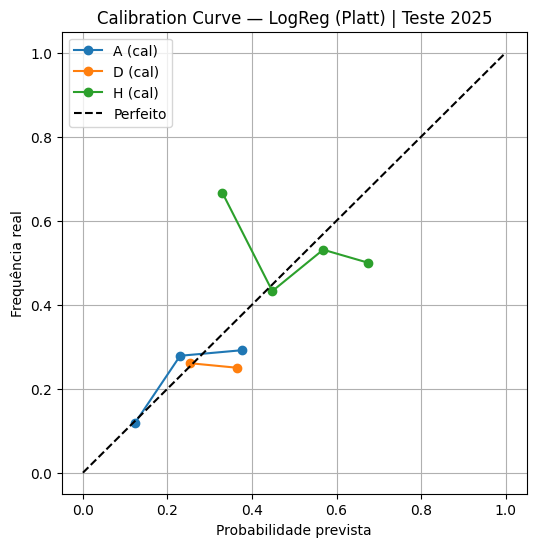

In [27]:
# =========================
# Load splits (FD)
# =========================
train_df = pd.read_parquet(INTERIM / "fd_2012_2023.parquet").copy()
cal_df   = pd.read_parquet(INTERIM / "fd_2024.parquet").copy()
test_df  = pd.read_parquet(INTERIM / "fd_2025.parquet").copy()

for d in (train_df, cal_df, test_df):
    d["data"] = pd.to_datetime(d["data"], errors="coerce")
    d.dropna(subset=["data"], inplace=True)
    d.sort_values("data", inplace=True)

print("Train:", train_df.shape, "| years:", train_df["ano_campeonato"].min(), "→", train_df["ano_campeonato"].max())
print("Cal  :", cal_df.shape,   "| years:", cal_df["ano_campeonato"].min(), "→", cal_df["ano_campeonato"].max())
print("Test :", test_df.shape,  "| years:", test_df["ano_campeonato"].min(), "→", test_df["ano_campeonato"].max())

# =========================
# Build features
# =========================
from src.data.features import build_features, FeatureConfig

cfg = FeatureConfig(rolling_n=5)

train_feat = build_features(train_df, cfg)
cal_feat   = build_features(cal_df, cfg)
test_feat  = build_features(test_df, cfg)

# 🔒 MESMA LISTA DO BASELINE (sem vazamento)
BASELINE_FEATURES = [
    "ano_campeonato",
    "league_gf_home_mean",
    "league_gf_away_mean",
    "league_total_goals_mean",

    "home_gf_roll","home_ga_roll",
    "home_gf_roll_home","home_ga_roll_home",
    "home_gf_roll_away","home_ga_roll_away",
    "home_games_played_lag1",

    "away_gf_roll","away_ga_roll",
    "away_gf_roll_home","away_ga_roll_home",
    "away_gf_roll_away","away_ga_roll_away",
    "away_games_played_lag1",

    "home_attack_roll","home_defense_roll",
    "away_attack_roll","away_defense_roll",
    "attack_gap","defense_gap",
]

# =========================
# Matrices + imputação
# =========================
X_train = train_feat[BASELINE_FEATURES].fillna(0)
y_train = train_feat["resultado"].copy()

X_cal = cal_feat[BASELINE_FEATURES].fillna(0)
y_cal = cal_feat["resultado"].copy()

X_test = test_feat[BASELINE_FEATURES].fillna(0)
y_test = test_feat["resultado"].copy()

print("Shapes:", X_train.shape, X_cal.shape, X_test.shape)

# =========================
# Model base (LogReg)
# =========================
logreg = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=2000,
            n_jobs=-1,
            random_state=42
        ))
    ]
)

logreg.fit(X_train, y_train)

# =========================
# Calibração (Platt) usando 2024
# =========================
calibrated_model = CalibratedClassifierCV(
    estimator=logreg,
    method="sigmoid",
    cv="prefit"
)
calibrated_model.fit(X_cal, y_cal)

# =========================
# Avaliação FINAL em 2025
# =========================
proba_base = logreg.predict_proba(X_test)
proba_cal  = calibrated_model.predict_proba(X_test)

classes = logreg.named_steps["model"].classes_
pred_base = logreg.predict(X_test)
pred_cal  = calibrated_model.predict(X_test)

ll_base = log_loss(y_test, proba_base, labels=classes)
ll_cal  = log_loss(y_test, proba_cal, labels=classes)

acc_base = accuracy_score(y_test, pred_base)
acc_cal  = accuracy_score(y_test, pred_cal)

y_bin = label_binarize(y_test, classes=classes)

brier_base = {c: brier_score_loss(y_bin[:, i], proba_base[:, i]) for i, c in enumerate(classes)}
brier_cal  = {c: brier_score_loss(y_bin[:, i], proba_cal[:, i])  for i, c in enumerate(classes)}

print("\n=== TESTE FINAL (2025) ===")
print("Log Loss — Base:", round(ll_base, 4))
print("Log Loss — Cal :", round(ll_cal, 4))
print("Accuracy — Base:", round(acc_base, 4))
print("Accuracy — Cal :", round(acc_cal, 4))
print("Brier médio — Base:", float(np.mean(list(brier_base.values()))))
print("Brier médio — Cal :", float(np.mean(list(brier_cal.values()))))

# =========================
# Calibration curve (bins menores)
# =========================
plt.figure(figsize=(6,6))
for i, c in enumerate(classes):
    frac_pos, mean_pred = calibration_curve(y_bin[:, i], proba_cal[:, i], n_bins=6)
    plt.plot(mean_pred, frac_pos, marker="o", label=f"{c} (cal)")

plt.plot([0,1], [0,1], "k--", label="Perfeito")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência real")
plt.title("Calibration Curve — LogReg (Platt) | Teste 2025")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import joblib
from pathlib import Path

PROJECT = Path("/content/drive/MyDrive/DataProjects/BRMP-Brazilian-Match-Prediction")
MODELS_DIR = PROJECT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

base_path = MODELS_DIR / "logreg_baseline_train_2012_2023.pkl"
cal_path  = MODELS_DIR / "logreg_calibrated_platt_train_2012_2023_cal_2024.pkl"

joblib.dump(logreg, base_path)
joblib.dump(calibrated_model, cal_path)

print("✅ Baseline salvo:", base_path)
print("✅ Calibrado salvo:", cal_path)


✅ Baseline salvo: /content/drive/MyDrive/DataProjects/BRMP-Brazilian-Match-Prediction/models/logreg_baseline_train_2012_2023.pkl
✅ Calibrado salvo: /content/drive/MyDrive/DataProjects/BRMP-Brazilian-Match-Prediction/models/logreg_calibrated_platt_train_2012_2023_cal_2024.pkl
